In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

from utils import get_observed_node_sets

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Load in datasets.
observed_node_sets, observed_node_sets_outliers = get_observed_node_sets(reconvert=True)

In [28]:
# For every scene in the dataset, parse it with both methods. Save the top N trees and runtime stats.

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = torch.eye(4)
)

# Was tempted to use a class here, but it gives trouble with pickling
# unpickling interacting with autoreload. So, ugly dict it is...
def make_parsinginfo_dict(
    mip_trees, mip_tree_scores,
    success, mip_time
):
    return {
        "mip_trees": mip_trees,
        "mip_tree_scores": mip_tree_scores,
        "success": success,
        "mip_time": mip_time
    }

def parse_all_scenes(N_solutions, strategy):
    assert strategy in ["mip", "ip"]
    
    parsing_infos = []
    for k in tqdm(range(len(observed_node_sets)), desc="Samples"):
        pyro.set_rng_seed(0)
        observed_nodes = observed_node_sets[k]

        start = time.time()
        if strategy == "mip":
            inference_results = infer_mle_tree_with_mip(
                grammar, observed_nodes, verbose=False, max_scene_extent_in_any_dir=10., N_solutions=N_solutions
            )
            parse_trees = get_optimized_trees_from_mip_results(inference_results)
            
        elif strategy == "ip":
            # Proposes not needed for this scene, since it's
            # a dependency grammar.
            #proposed_poses_by_type = generate_candidate_node_pose_sets(
            #    grammar, observed_nodes, max_recursion_depth=10, verbose=False
            #)
            parse_trees = infer_mle_tree_with_mip_from_proposals(
                grammar, observed_nodes, {}, verbose=False, N_solutions=N_solutions,
                min_ll_for_consideration=-1000.
            )
        mip_done = time.time()
        

        if len(parse_trees) == 0:
            logging.error("Failed an inference! Results invalid")
            parsing_infos.append(
                make_parsinginfo_dict(
                    mip_trees=[],
                    mip_tree_scores=[],
                    success=False,
                    mip_time=0,
                )
            )
        else:
            parsing_infos.append(
                make_parsinginfo_dict(
                    mip_trees=[cleanup_tree_for_pickling(tree) for tree in parse_trees],
                    mip_tree_scores=[tree.score() for tree in parse_trees],
                    success=True,
                    mip_time=mip_done-start,
                )
            )
    return parsing_infos

bar = tqdm(["ip", "mip"])
results_by_strategy = {}
for strategy in bar:
    bar.set_description("technique: %s" % strategy)
    results_by_strategy[strategy] = parse_all_scenes(N_solutions=10, strategy=strategy)

  0%|          | 0/2 [00:00<?, ?it/s]

Samples:   0%|          | 0/30 [00:00<?, ?it/s]

Samples:   0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
with open("parsing_statistics_runs.pickle", "wb") as f:
    pickle.dump(results_by_strategy, f)

# Data analysis and plotting.

In [31]:
# Plotting
with open("parsing_statistics_runs.pickle", "rb") as f:
    results_by_strategy = pickle.load(f)

([<matplotlib.axis.XTick at 0x7fdfa396af98>,
 [Text(0, 0, 'MICP'), Text(1, 0, 'IP')])

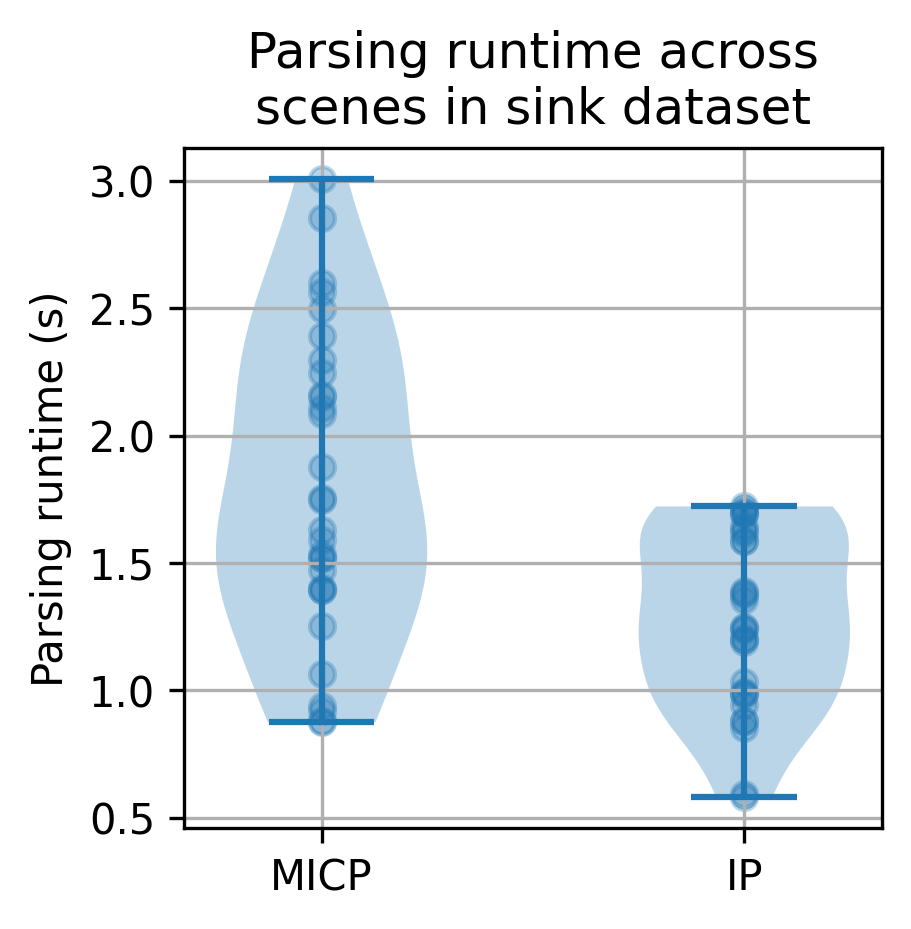

In [32]:
# Plot runtime distribution of each technique
list_of_times = []
labels = []
for k, (strategy, superlabel) in enumerate(zip(["mip", "ip"], ["MICP", "IP"])):
    results = results_by_strategy[strategy]
    times = [info["mip_time"] for info in results]
    list_of_times.append(times)
    labels.append(superlabel)

plt.figure(dpi=300).set_size_inches(3, 3)
parts = plt.violinplot(list_of_times, positions=range(2))

for k, (pc, times) in enumerate(zip(parts['bodies'], list_of_times)):
    c = pc.get_facecolor()
    plt.scatter(np.ones(len(times))*k, times, c=c)

#plt.ylim(0.01, 100.)
plt.title("Parsing runtime across\nscenes in sink dataset")
plt.grid(True)
plt.ylabel("Parsing runtime (s)")
plt.xticks([0, 1], labels, rotation=0)

Max disagreement between scores:  1.60530257620195e-05


Text(0, 0.5, 'Relative occurance')

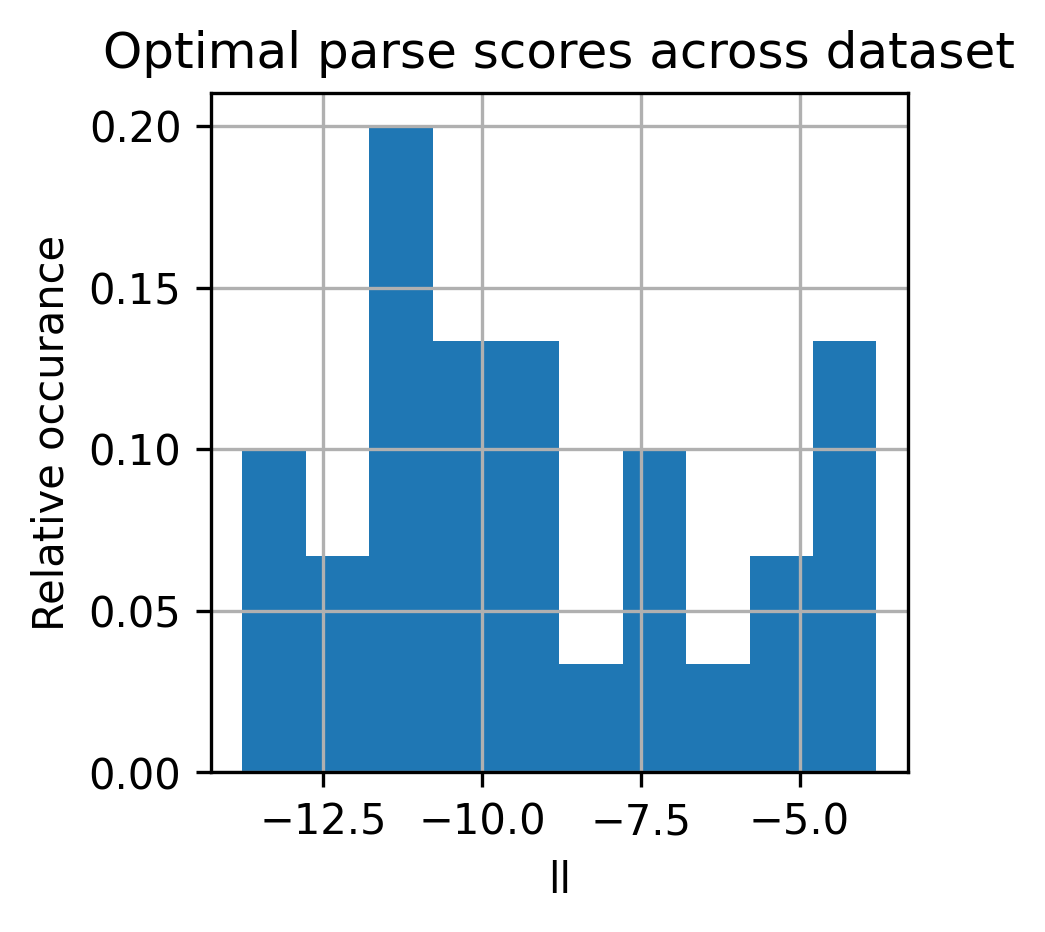

In [38]:
micp_lls = []
ip_lls = []
for micp_info, ip_info in zip(results_by_strategy["mip"], results_by_strategy["ip"]):
    micp_lls.append(np.max(micp_info["mip_tree_scores"]))
    ip_lls.append(np.max(ip_info["mip_tree_scores"]))
print("Max disagreement between scores: ", np.max(np.abs(np.array(micp_lls) - np.array(ip_lls))))

plt.figure(dpi=300).set_size_inches(3, 3)
plt.hist(ip_lls, density=True)
plt.grid()
plt.title("Optimal parse scores across dataset")
plt.xlabel("ll")
plt.ylabel("Relative occurance")